In [1]:
from pydub import AudioSegment
import whisper as whisper
import os
import pandas as pd
from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [9]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Searc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
#classify sentiment
def classify_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return "Positive"
    elif scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
#single video file
def process_video(mp4_file):
    """
    Processes an MP4 file: extracts audio, segments it, transcribes text, 
    analyzes sentiment, and saves the results in a CSV file.

    Args:
        mp4_file (str): The path to the video file.

    Returns:
        str: Path to the generated CSV file.
    """
    print(f"Processing: {mp4_file}")

    #check the exsistence
    if not os.path.exists(mp4_file):
        print(f"Error: File '{mp4_file}' not found.")
        return None

    #MP4 to WAV (16kHz, mono)
    wav_file = mp4_file.replace(".mp4", ".wav")
    audio = AudioSegment.from_file(mp4_file, format="mp4")
    audio = audio.set_frame_rate(16000).set_channels(1)
    audio.export(wav_file, format="wav")

    #Whisper model
    model = whisper.load_model("base")

    #segment audio into 5s chunks
    chunk_length_ms = 5000  # 5 seconds
    chunks = [audio[i:i + chunk_length_ms] for i in range(0, len(audio), chunk_length_ms)]

    #store results
    data = []

    for i, chunk in enumerate(chunks):
        start_time = i * 5  # Start time in seconds
        chunk_filename = f"chunk_{i}.wav"
        chunk.export(chunk_filename, format="wav")

        #transcribe with Whisper
        result = model.transcribe(chunk_filename)
        text = result["text"].strip()

        #sentiment analysis
        sentiment = classify_sentiment(text) if text else "Neutral"

        #store data
        data.append({
            "Timestamp (s)": start_time,
            "Transcription": text,
            "Sentiment": sentiment
        })

        print(f"[{start_time}s] {text} - Sentiment: {sentiment}")

        os.remove(chunk_filename)  #cleanup

    df = pd.DataFrame(data)

    #csv
    output_dir = "transcriptions"
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = os.path.join(output_dir, f"transcription_{timestamp}.csv")

    #save
    df.to_csv(csv_filename, index=False, encoding="utf-8")
    print(f"\nTranscription complete. Saved to: {csv_filename}")

    return csv_filename



In [ ]:
#process multiple videos
def process_all_videos(video_folder):
    """
    Processes all MP4 files in a given folder.

    Args:
        video_folder (str): Path to the directory containing video files.
    """
    print(f"Scanning directory: {video_folder}")

    video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]
    
    if not video_files:
        print("No video files found in the directory.")
        return

    for video in video_files:
        video_path = os.path.join(video_folder, video)
        process_video(video_path)

In [13]:
#process for single video
if __name__ == "__main__":
    video_file = "Experimenter_CREW.mp4" 
    csv_output = process_video(video_file)

Processing: Experimenter_CREW.mp4
[0s]  - Sentiment: Neutral
[5s] Okay, so the - Sentiment: Positive
[10s] you're going to complete and use the key and the object detection system so that means you will not need to. - Sentiment: Neutral
[15s] operate vehicle, checking your needs off the steering wheel and meet up the pedals, once we begin that drive. - Sentiment: Neutral
[20s] Okay, so when you see that some driver indicator highlight green make sure you don't get the break at any point during - Sentiment: Positive
[25s] drive. This dot the car cab look at will have the hood yes for getting visual - Sentiment: Positive
[30s] for targets that are in the environment. The car cabboultch, outshapage, that screen, tape them. - Sentiment: Neutral
[35s] and it went out to turn the mission. Remember to tap the targets on that ODS as well as completing the booth. - Sentiment: Positive
[40s] on board. Sometimes you can see all his workstation tests. - Sentiment: Neutral
[45s] Alright, so all dri

In [14]:
import matplotlib.pyplot as plt
import numpy as np
def load_transcription_data(filepath):
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None
    return pd.read_csv(filepath)

In [ ]:
def plot_word_histogram(df):
    """
    Generates a histogram of word counts per 5-second interval.

    Args:
        df (pandas.DataFrame): The transcription dataframe.
    """
    df["Bucket"] = df["Timestamp (s)"] // 5 * 5  #group into 5s intervals

    #clean transcriptions(ensure all String)
    df["Transcription"] = df["Transcription"].astype(str).fillna("")

    #count words per time bucket
    word_counts = df.groupby("Bucket")["Transcription"].apply(lambda x: sum(len(str(t).split()) for t in x)).reset_index()

    #Histogram
    plt.figure(figsize=(12, 6))
    plt.bar(word_counts["Bucket"], word_counts["Transcription"], width=5, align="edge")
    plt.xlabel("Time Buckets (seconds)")
    plt.ylabel("Word Count")
    plt.title("Histogram of Transcribed Words per 5-Second Interval")
    x_ticks = word_counts["Bucket"].values
    plt.xticks(x_ticks[::3]) 
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


In [ ]:
def plot_sentiment_distribution(df):
    """
    Generates a pie chart showing sentiment classification distribution.

    Args:
        df (pandas.DataFrame): The transcription dataframe.
    """
    sentiment_counts = df["Sentiment"].value_counts()

    plt.figure(figsize=(8, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140, colors=["green", "red", "gray"])
    plt.title("Sentiment Distribution")
    plt.show()

Processing transcription_20250315_165715.csv...


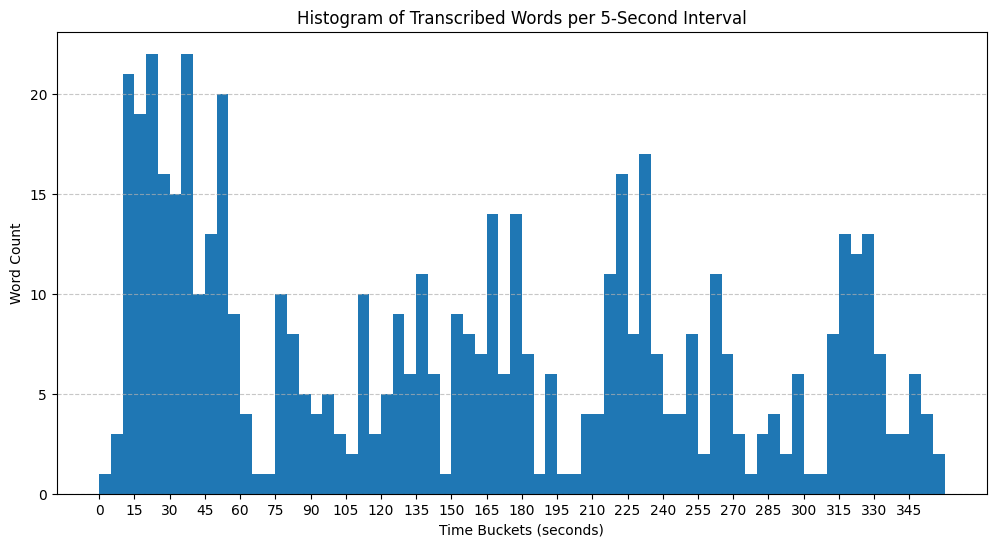

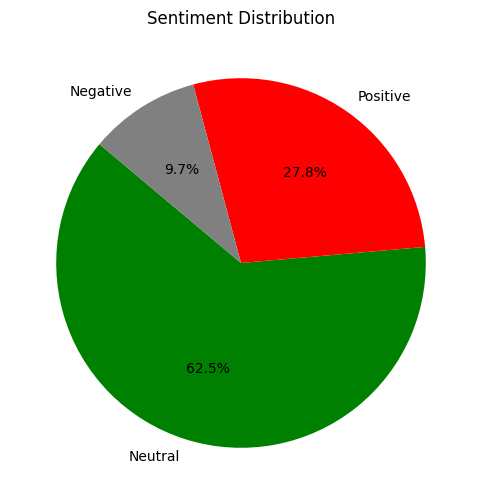

In [ ]:
def process_all_csv():
    transcriptions_folder = "transcriptions"

    if not os.path.exists(transcriptions_folder):
        print(f"Error: Folder '{transcriptions_folder}' does not exist.")
        return

    csv_files = [f for f in os.listdir(transcriptions_folder) if f.endswith(".csv")]

    if not csv_files:
        print("No transcription CSV files found in the folder.")
        return

    #process each CSV
    for csv_file in csv_files:
        csv_path = os.path.join(transcriptions_folder, csv_file)
        df = load_transcription_data(csv_path)

        if df is not None:
            print(f"Processing {csv_file}...")
            plot_word_histogram(df) #Histogram
            plot_sentiment_distribution(df) #Sentiment Distribution

if __name__ == "__main__":
    process_all_csv()